In [1]:
import json
import geatpy as ea
from utils import get_png_paths, scan,char_id_mapping, action_id_mapping

In [2]:
import numpy as np
import geatpy as ea
import time
import random
class CardMatchPop(ea.Population):
    def set_cards(self, cards):
        #print("我服辣")
        self.cards = cards
    def set_field(self, lbs,ubs,types):
        self.Field = np.vstack((np.array(lbs),np.array(ubs),np.array(types)))
    def initChrom(self, NIND):
        #print("妈妈生的")
        if NIND is not None:
            self.sizes = NIND  # 重新设置种群规模
        if self.cards is None:
            raise ValueError("cards not initialized")
        var_nums = self.Field.shape[1]
        res = []
        now = time.time()
        for i in range(self.sizes):
            twos = random.randint(0, self.cards//2 - 1)
            t = [2]*twos + [1]*(self.cards-twos) + [0]*(var_nums - self.cards)
            np.random.shuffle(t)
            res.append(t)
        print("init pop cost {}s".format(time.time()-now),flush= True)
        self.Chrom = np.array(res)
        self.Lind = self.Chrom.shape[1]  # 计算染色体的长度
        self.ObjV = None
        self.FitnV = None
        self.CV = None
        
def BestChars(CharComfort:np.ndarray, selected_char):
    """给定一个角色的id,返回他的最佳队友"""
    charnum = CharComfort.shape[0]
    best_pair = (0,0)
    best_scores = float('-inf')
    for j in range(charnum):
        if j == selected_char:
            continue
        for k in range(charnum):
            if k == j or k == selected_char:
                continue
            scores = CharComfort[selected_char,j] + CharComfort[j,k] + CharComfort[selected_char,k]
            if scores > best_scores:
                best_pair = (j ,k)
                best_scores = scores
    return best_pair
def MatchCardGA(comfort,selected_chars, c2a , card_num = 30, try_algo = 3, NIND = 500, ITERS = 300):
    cards = card_num
    sigma = 0.82
    N = comfort.shape[0]
    portion = 0.05
    weight = np.zeros(N)
    for char_idx in selected_chars:
        weight += c2a[char_idx, :].flatten()
    @ea.Problem.single
    def evalVars(Vars):
        f = np.dot(np.dot(Vars, comfort), Vars) + np.dot(weight, Vars)
        CV = np.array([np.abs(np.sum(Vars) - cards)])
        return f, CV
    prob = ea.Problem(
        name = "Card Matching",
        M = 1,
        maxormins = [-1],
        Dim = comfort.shape[0],
        varTypes=[1]*comfort.shape[0],
        lb = [0]*N,
        ub = [2]*N,
        evalVars=evalVars
    )
    Pop = CardMatchPop(Encoding='RI',NIND = NIND)
    Pop.set_cards(cards)
    Pop.set_field([0]*N,[2]*N,[1]*N)
    print(type(Pop))
    if try_algo == 0:
        pass
    elif try_algo == 1:
        algorithm = ea.soea_SGA_templet(
            problem = prob,
            population=Pop,
            MAXGEN=ITERS,
            trappedValue=1e-8,
            maxTrappedCount=10,logTras= 0
        )
    elif try_algo == 2:
        algorithm = ea.soea_DE_best_1_bin_templet(
            problem = prob,
            population=Pop,
            MAXGEN=ITERS,
            trappedValue=1e-5,
            maxTrappedCount=10,logTras= 0
        )
    elif try_algo == 3:
        ##最快且解最好.
        algorithm = ea.soea_GGAP_SGA_templet(
            problem = prob,
            population=Pop,
            MAXGEN=ITERS,
            trappedValue=1e-6,
            maxTrappedCount=ITERS//10,
            logTras= 0
        )
    #algorithm.mutOper.Parallel = True
    print(type(Pop))
    print(type(algorithm.population))
    res = ea.optimize(algorithm,outputMsg=True,drawLog=True,saveFlag=False)
    if res['Vars'] is None:
        return None
    return res['Vars'].flatten()

In [3]:
class Trainer:
    def __init__(self, act_card_idpath,
                 char_card_idpath,
                 id_actpath,
                 id_charpath,
                 deck_path):
        with open(act_card_idpath) as act:
            self.act_id = json.load(act)
        with open(char_card_idpath) as char:
            self.char_id = json.load(char)
        with open(id_actpath) as id_act:
            temp = json.load(id_act)
            self.id_act = {}
            for key in temp.keys():
                self.id_act[int(key)] = temp[key]
        with open(id_charpath) as id_char:
            temp = json.load(id_char)
            self.id_char = {}
            for key in temp.keys():
                self.id_char[int(key)] = temp[key]
        self.dataset = get_png_paths(deck_path)
        self.actnum = len(self.act_id)
        self.charnum = len(self.char_id)
        self.CharComfort = None
        self.CharPreferAct = None
        self.ActComfort = None
    def ifpermit(self, chars, card):
        """检查chars和card是否合法.
        chars: 一个长度为3的字典, key=char名, value=char_id
        card: 长度为1的字典, key=card_name ,value=card_id
        """
        return True
    def _update(self, scan_dict):
        chars = scan_dict['characters']
        actions = scan_dict['actions']
        for char in chars.keys():
            cid = self.char_id[char]
            self.cfreq[cid] += 1
            for pchar in chars.keys():
                if pchar != char:
                    pcid = self.char_id[pchar]
                    self.c2c[cid][pcid] += 1
            for act in actions.keys():
                aid = self.act_id[act]
                self.c2a[cid][aid] += actions[act]
        for act in actions.keys():
            aid = self.act_id[act]
            self.afreq[aid] += actions[act]
            for pact in actions.keys():
                paid = self.act_id[pact]
                self.a2a[aid][paid] += actions[pact]
    def train(self, cfreq_path = './cfreq.npy',
              afreq_path = './afreq.npy',
              c2c_path = './c2c.npy',
             c2a_path = './c2a.npy',
             a2a_path = './a2a.npy'):
        """根据dataset进行训练. 这个函数将从头学习.
        """
        self.cfreq = np.zeros(self.charnum)
        self.afreq = np.zeros(self.actnum)
        self.c2c = np.zeros((self.charnum, self.charnum))
        self.c2a = np.zeros((self.charnum, self.actnum))
        self.a2a = np.zeros((self.actnum, self.actnum))
        for data in self.dataset:
            self._update(scan(data))
        wc = np.divide(np.ones(self.charnum), self.cfreq, out = np.zeros_like(self.cfreq), where=self.cfreq != 0)
        wa = np.divide(np.ones_like(self.afreq), self.afreq, out = np.zeros_like(self.afreq), where=self.afreq != 0)
        self.CharComfort = self.c2c* wc[:,None]##每一行都除
        self.ActComfort = self.a2a * wa[:,None]
        self.CharPreferAct = self.c2a * wc[:, None]
        np.save(cfreq_path, self.cfreq)
        np.save(afreq_path, self.afreq)
        np.save(c2c_path, self.c2c)
        np.save(c2a_path, self.c2a)
        np.save(a2a_path, self.a2a)
        print("train finished")
    def learn(self, total_path = './total.npy',
              c2c_path = './c2c.npy',
             c2a_path = './c2a.npy',
             a2a_path = './a2a.npy'):
        """根据dataset进行训练. 这个函数不会从头学习, 因此必须保证dataset从未训练过!
        """
        pass
    def load(self, cfreq_path = './cfreq.npy',
              afreq_path = './afreq.npy',
              c2c_path = './c2c.npy',
             c2a_path = './c2a.npy',
             a2a_path = './a2a.npy'):
        self.cfreq = np.load(cfreq_path)
        self.afreq = np.load(afreq_path)
        self.c2c = np.load(c2c_path)
        self.c2a = np.load(c2a_path)
        self.a2a = np.load(a2a_path)
        wc = np.divide(np.ones(self.charnum), self.cfreq, out = np.zeros_like(self.cfreq), where=self.cfreq != 0)
        wa = np.divide(np.ones_like(self.afreq), self.afreq, out = np.zeros_like(self.afreq), where=self.afreq != 0)
        self.CharComfort = self.c2c* wc[:,None]##每一行都除
        self.ActComfort = self.a2a * wa[:,None]
        self.CharPreferAct = self.c2a * wc[:, None]
    def predict(self, character_name):
        if self.CharComfort is None:
            print("please load data first")
            return None
        cid = self.char_id[character_name]
        res = {}
        pal1, pal2 = BestChars(self.CharComfort, cid)
        #print(self.id_char)
        res['chars'] = (self.id_char[cid], self.id_char[pal1], self.id_char[pal2])
        cards = MatchCardGA(self.ActComfort, (cid,pal1,pal2),self.CharPreferAct)
        selected_indices = np.nonzero(cards)[0]
        deck = {}
        print(selected_indices)
        for i in range(len(selected_indices)):
            idx = selected_indices[i]
            deck[self.id_act[idx]] = cards[idx]
        res['deck'] = deck
        print("推荐卡组:")
        print(res)
        return res

In [4]:
if False:
    char_id_mapping()
    action_id_mapping()

In [5]:
from pathlib import Path
abs_path = str(Path("__file__").parent.absolute())
T = Trainer('action_id.json','char_id.json',
            'id_action.json','id_char.json',abs_path + '\\'+ 'scanner\\python\\datasets')

<class '__main__.CardMatchPop'>
<class '__main__.CardMatchPop'>
<class '__main__.CardMatchPop'>
init pop cost 0.012998819351196289s


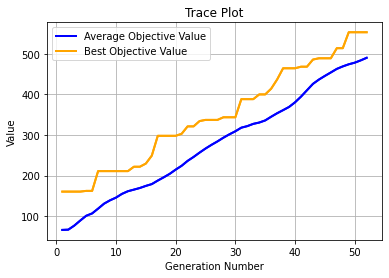

Execution time: 6.2582480907440186 s
Evaluation number: 26000
The best objective value is: 553.1087662337662
The best variables are: 
0	1	0	0	0	0	0	0	0	0	1	1	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	2	1	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	2	0	0	0	1	1	1	0	0	0	0	0	1	0	2	0	0	1	0	0	0	0	0	1	0	0	0	0	1	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	1	
[  1  10  11  12  24  39  44  45  47  59  63  67  68  69  75  77  80  86
  91  98 110 113 120 129 135]
推荐卡组:
{'chars': ('fischl', 'collei', 'mona'), 'deck': {'adeptus_temptation': 1, 'calxs_arts': 1, 'changing_shifts': 1, 'chang_the_ninth': 1, 'elemental_resonance_fervent_flames': 1, 'favonius_cathedral': 2, 'gamblers_earrings': 2, 'general_helm': 1, 'grand_expectation': 1, 'knights_of_favonius_library': 1, 'leave_it_to_me!': 2, 'liu_su': 1, 'liyue_harbor_wharf': 1, 'lotus_flower_crisp': 1, 'minty_meat_rolls': 1, 'mondstadt_hash_brown': 2, 'northern_smoked_chicken': 1, 'parametric_trans

{'chars': ('fischl', 'collei', 'mona'),
 'deck': {'adeptus_temptation': 1,
  'calxs_arts': 1,
  'changing_shifts': 1,
  'chang_the_ninth': 1,
  'elemental_resonance_fervent_flames': 1,
  'favonius_cathedral': 2,
  'gamblers_earrings': 2,
  'general_helm': 1,
  'grand_expectation': 1,
  'knights_of_favonius_library': 1,
  'leave_it_to_me!': 2,
  'liu_su': 1,
  'liyue_harbor_wharf': 1,
  'lotus_flower_crisp': 1,
  'minty_meat_rolls': 1,
  'mondstadt_hash_brown': 2,
  'northern_smoked_chicken': 1,
  'parametric_transformer': 1,
  'raven_bow': 1,
  'send_off': 2,
  'strategize': 1,
  'the_bestest_travel_companion!': 1,
  'toss-up': 1,
  'wangshu_inn': 1,
  'wolfs_gravestone': 1}}

In [6]:
T.load()
T.predict("fischl")

<class '__main__.CardMatchPop'>
<class '__main__.CardMatchPop'>
<class '__main__.CardMatchPop'>
init pop cost 0.007999897003173828s


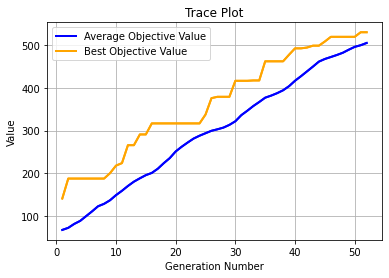

Execution time: 6.044647932052612 s
Evaluation number: 26000
The best objective value is: 529.3071428571428
The best variables are: 
0	1	0	0	0	0	0	0	0	0	0	0	1	0	1	0	0	0	0	0	1	0	0	0	1	0	0	0	2	0	1	0	0	0	1	0	0	0	0	2	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	2	0	0	0	1	1	0	0	0	1	0	0	0	1	2	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	1	0	0	0	0	0	1	1	0	0	0	0	0	
[  1  12  14  20  24  28  30  34  39  45  52  59  64  68  69  73  77  78
  85  94 113 120 123 129 130]
推荐卡组:
{'chars': ('kokomi', 'diona', 'mona'), 'deck': {'adeptus_temptation': 1, 'chang_the_ninth': 1, 'chef_mao': 1, 'dawn_winery': 1, 'elemental_resonance_fervent_flames': 1, 'elemental_resonance_soothing_water': 2, 'elemental_resonance_woven_flames': 1, 'elemental_resonance_woven_waters': 1, 'favonius_cathedral': 2, 'general_helm': 1, 'iron_tongue_tian': 1, 'knights_of_favonius_library': 1, 'liben': 2, 'liyue_harbor_wharf': 1, 'lotus_flower_crisp': 1, 'master_of_weaponry': 1, 'mondstad

{'chars': ('kokomi', 'diona', 'mona'),
 'deck': {'adeptus_temptation': 1,
  'chang_the_ninth': 1,
  'chef_mao': 1,
  'dawn_winery': 1,
  'elemental_resonance_fervent_flames': 1,
  'elemental_resonance_soothing_water': 2,
  'elemental_resonance_woven_flames': 1,
  'elemental_resonance_woven_waters': 1,
  'favonius_cathedral': 2,
  'general_helm': 1,
  'iron_tongue_tian': 1,
  'knights_of_favonius_library': 1,
  'liben': 2,
  'liyue_harbor_wharf': 1,
  'lotus_flower_crisp': 1,
  'master_of_weaponry': 1,
  'mondstadt_hash_brown': 1,
  'mushroom_pizza': 2,
  'paimon': 2,
  'sacrificial_bow': 1,
  'the_bestest_travel_companion!': 1,
  'toss-up': 1,
  'traveling_doctors_handkerchief': 1,
  'wangshu_inn': 1,
  'when_the_crane_returned': 1}}

In [7]:
T.predict("kokomi")

<class '__main__.CardMatchPop'>
<class '__main__.CardMatchPop'>
<class '__main__.CardMatchPop'>
init pop cost 0.005003690719604492s


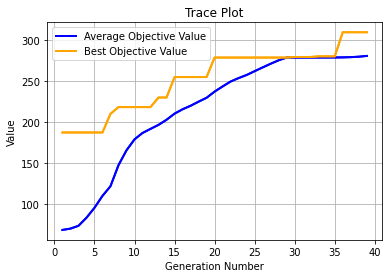

Execution time: 2.3598990440368652 s
Evaluation number: 19500
The best objective value is: 309.8995670995671
The best variables are: 
1	1	0	0	0	0	0	0	0	0	1	0	1	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	1	1	0	1	0	0	0	0	0	1	0	0	1	1	1	0	0	0	0	0	0	1	0	1	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	1	2	0	0	0	0	0	0	1	0	0	0	0	0	1	0	0	1	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	1	1	1	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	
[  0   1  10  12  14  25  31  32  34  40  43  44  45  52  54  60  63  77
  78  85  91  94  98 105 111 112 113 119 135]
推荐卡组:
{'chars': ('mona', 'collei', 'fischl'), 'deck': {'abyssal_summons': 1, 'adeptus_temptation': 1, 'calxs_arts': 1, 'chang_the_ninth': 1, 'chef_mao': 1, 'elemental_resonance_high_voltage': 1, 'elemental_resonance_woven_ice': 1, 'elemental_resonance_woven_stone': 1, 'elemental_resonance_woven_waters': 1, 'featherfall_judgment': 1, 'frostflake_seki_no_to': 1, 'gamblers_earrings': 1, 'general_helm': 1, 'iron_tongue_tian': 1, 'i_havent_lost_yet!': 1, 'lands_of_dandelion'

{'chars': ('mona', 'collei', 'fischl'),
 'deck': {'abyssal_summons': 1,
  'adeptus_temptation': 1,
  'calxs_arts': 1,
  'chang_the_ninth': 1,
  'chef_mao': 1,
  'elemental_resonance_high_voltage': 1,
  'elemental_resonance_woven_ice': 1,
  'elemental_resonance_woven_stone': 1,
  'elemental_resonance_woven_waters': 1,
  'featherfall_judgment': 1,
  'frostflake_seki_no_to': 1,
  'gamblers_earrings': 1,
  'general_helm': 1,
  'iron_tongue_tian': 1,
  'i_havent_lost_yet!': 1,
  'lands_of_dandelion': 1,
  'leave_it_to_me!': 1,
  'mondstadt_hash_brown': 1,
  'mushroom_pizza': 2,
  'paimon': 1,
  'raven_bow': 1,
  'sacrificial_bow': 1,
  'send_off': 1,
  'starsigns': 1,
  'streaming_surge': 1,
  'sweet_madame': 1,
  'the_bestest_travel_companion!': 1,
  'timmie': 1,
  'wolfs_gravestone': 1}}

In [8]:
T.predict("mona")